# Ensemble Methods

In [1]:
# Main data packages. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imblearn

import datetime

import warnings
warnings.filterwarnings('ignore')

## Data

For input data we are concentrating on those data sets which performed well with our PCA approach:

1. df_7
2. df_10_compact
3. df_11_compact
4. df_12_compact
5. df_13
6. df_14

Those DataFrames with "compact" in their names are based on other Dataframes BUT only contain those features which had at least some correlation with the target value "rebap_eur_mwh". This correaltion was identified via Seaborn correlation map.

In [2]:
df_7 = pd.read_csv("data/PCA Data Sets/EQ_epex_da_last_prognosis_count.csv")

In [3]:
df_7['timestamp']=df_7['timestamp'].astype('datetime64')

In [4]:
df_10 = pd.read_csv("data/PCA Data Sets/es_fc_total_renewables_ts.csv")

In [5]:
df_10['dt_start_utc']=df_10['dt_start_utc'].astype('datetime64')

In [6]:
df_10_compact = df_10[['dt_start_utc', "TTG_power_mw"]].copy()

In [7]:
df_11 = pd.read_csv("data/PCA Data Sets/es_fc_wind_offshore_ts.csv")

In [8]:
df_11['dt_start_utc']=df_11['dt_start_utc'].astype('datetime64')

In [9]:
df_11_compact = df_11[['dt_start_utc', "DE_power_mw", "TTG_power_mw"]].copy()

In [10]:
df_12 = pd.read_csv("data/PCA Data Sets/es_fc_wind_onshore_ts.csv")

In [11]:
df_12['dt_start_utc']=df_12['dt_start_utc'].astype('datetime64')

In [12]:
df_12_compact = df_12[['dt_start_utc', "50Hertz_power_mw", "DE_power_mw", "TTG_power_mw"]].copy()

In [13]:
df_13 = pd.read_csv("data/PCA Data Sets/wind_speed_ts.csv")

In [14]:
df_13['dt_start_utc']=df_13['dt_start_utc'].astype('datetime64')

In [15]:
df_14 = pd.read_csv("data/PCA Data Sets/imbalance_de_labeled.csv")

In [16]:
df_14['dt_start_utc']=df_14['dt_start_utc'].astype('datetime64')

In [17]:
df_14 = df_14.drop(["power_mw"], axis=1)

In [18]:
from apymb import *

df_ensemble = align(df_7, df_10_compact, df_11_compact, df_12_compact, df_13, df_14)

## Filter out those rebap prizes that are not within 3 Standard deviations of the mean:

Now we will get rid of those rebap prize outliers outside the +/- 3 Standard Deviation range with the following code line:

In [19]:
std_dev = 3*df_ensemble['6_rebap_eur_mwh'].std()
df_ensemble = df_ensemble[np.abs(df_ensemble['6_rebap_eur_mwh'] - df_ensemble['6_rebap_eur_mwh'].mean()) <= std_dev]

### Define new classification column named "rebap_price_class" in which the rebap price_range is translated to two classes:

- Class 0: Rebap prize below 0 €
- Class 1: Rebap prize above 0 €

In [20]:
df_ensemble["rebap_price_class"] = np.nan
for i in range (len(df_ensemble["rebap_price_class"])):
    if df_ensemble["6_rebap_eur_mwh"][i] <= 0:
        df_ensemble["rebap_price_class"][i] = 0
    else:
        df_ensemble["rebap_price_class"][i]= 1
        
df_ensemble["rebap_price_class"] = df_ensemble["rebap_price_class"].astype('int')

## Eliminate the original target feature "rebap_eur_mwh" from the Dataframe (we want to predict the target class in "rebap_price_class":

In [21]:
df_ensemble = df_ensemble.drop(['6_rebap_eur_mwh'], axis= 1)

## Train-test Split plus Smote for the Training Data Set

In [27]:
from sklearn.model_selection import train_test_split
X = df_ensemble.drop(["rebap_price_class"],axis=1)
y = df_ensemble["rebap_price_class"]
                     
hours_shift = 0

# Shift the Data to represent the fact that not all Data are available immediately
X = X.shift(int(hours_shift*4))
y = y[int(hours_shift*4):]
X = X.dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)                     

# balance out every target class imbalance via SMOTE (ONLY for the Training Data!):
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

## Define a train_predict function (taken from neuefische Notebook No.4 for ensemble Methods) that trains and evaluates different ML Models and returns the most important scores for each Model in a result list:

In [28]:
from time import time

# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

# Define a train and evaluation function 
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [29]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

# TODO: Initialize the three models, the random states are set to 101 so we know how to reproduce the model later
clf_A = RandomForestClassifier(random_state=42)
clf_B = DecisionTreeClassifier(random_state=42)
clf_C = AdaBoostClassifier(random_state=42)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

RandomForestClassifier trained on 700 samples.
RandomForestClassifier trained on 6996 samples.
RandomForestClassifier trained on 69960 samples.
DecisionTreeClassifier trained on 700 samples.
DecisionTreeClassifier trained on 6996 samples.
DecisionTreeClassifier trained on 69960 samples.
AdaBoostClassifier trained on 700 samples.
AdaBoostClassifier trained on 6996 samples.
AdaBoostClassifier trained on 69960 samples.


In [30]:
#Printing out the values
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

RandomForestClassifier


,1%,10%,100%
train_time,0.384412,5.133139,71.843065
pred_time,0.103583,0.198348,0.352325
acc_train,1.000000,1.000000,1.000000
acc_test,0.823624,0.830400,0.834165
f_train,1.000000,1.000000,1.000000
f_test,0.855719,0.865191,0.902169


DecisionTreeClassifier


,1%,10%,100%
train_time,0.041242,1.012125,12.613468
pred_time,0.006619,0.007306,0.009654
acc_train,1.000000,1.000000,1.000000
acc_test,0.745788,0.754918,0.750118
f_train,1.000000,1.000000,1.000000
f_test,0.844460,0.855043,0.869451


AdaBoostClassifier


,1%,10%,100%
train_time,0.342875,3.408232,38.359818
pred_time,0.123721,0.125208,0.144299
acc_train,0.910000,0.810000,0.716667
acc_test,0.787671,0.809882,0.674729
f_train,0.921659,0.861153,0.866733
f_test,0.854523,0.860860,0.846077


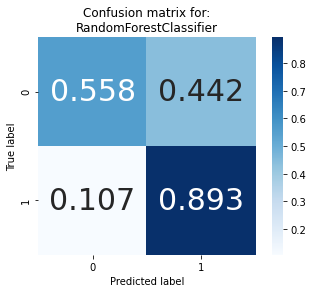

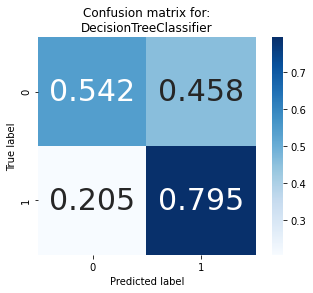

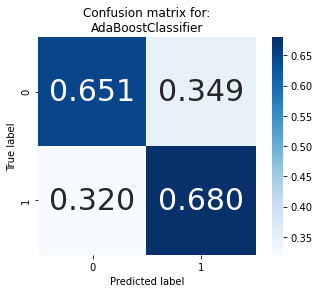

In [31]:
#Visualizing the confusion matrix for each classifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import seaborn as sns

for i,model in enumerate([clf_A,clf_B, clf_C]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));
    #plt.savefig(f'Confusion matrix for:{format(model.__class__.__name__)}.png', transparent=True)

# Try 5-Bucket classification with the Ensemble Methods
Let us now test how well our 3 Ensemble Methods work for a 5-Bucket approach of the target feature:
- class 0: Rebap price < ca. 20% Percentile
- class 1: Rebap price < ca. 40% Percentile
- class 2: Rebap price < ca. 60% Percentile
- class 3: Rebap price < ca. 80% Percentile
- class 4: Rebap price < ca. 100% Percentile

We do not take the precise values for the different percentiles, just a rounded approximation.

In [33]:
# We first have to define our dataframe:

df_ensemble_5_bucket = align(df_7, df_10_compact, df_11_compact, df_12_compact, df_13, df_14)

## Filter out again those rebap prizes that are not within 3 Standard deviations of the mean:

Now we will get rid of those rebap prize outliers outside the +/- 3 Standard Deviation range with the following code line:

In [34]:
std_dev = 3*df_ensemble_5_bucket['6_rebap_eur_mwh'].std()
df_ensemble_5_bucket = df_ensemble_5_bucket[np.abs(df_ensemble_5_bucket['6_rebap_eur_mwh'] - df_ensemble_5_bucket['6_rebap_eur_mwh'].mean()) <= std_dev]

## Calculate the percentile values for 20%, 40%, 60%, 80%, 100%:

In [35]:
rebap_20_percentile = df_ensemble_5_bucket["6_rebap_eur_mwh"].quantile(0.2)
rebap_40_percentile = df_ensemble_5_bucket["6_rebap_eur_mwh"].quantile(0.4)
rebap_60_percentile = df_ensemble_5_bucket["6_rebap_eur_mwh"].quantile(0.6)
rebap_80_percentile = df_ensemble_5_bucket["6_rebap_eur_mwh"].quantile(0.8)
rebap_100_percentile = df_ensemble_5_bucket["6_rebap_eur_mwh"].quantile(1)

print(rebap_20_percentile, rebap_40_percentile, rebap_60_percentile, rebap_80_percentile, rebap_100_percentile)

3.198000000000011 23.06 45.19 62.05 261.1


Create the new target column "rebap_price_class" based on the roughly rounded 20,40,60,80 and 100% percentiles: 

In [36]:
df_ensemble_5_bucket["rebap_price_class"] = np.nan
for i in range (len(df_ensemble_5_bucket["rebap_price_class"])):
    if df_ensemble_5_bucket["6_rebap_eur_mwh"][i] <= 3:
        df_ensemble_5_bucket["rebap_price_class"][i] = 0
    elif df_ensemble_5_bucket["6_rebap_eur_mwh"][i] <= 20:
        df_ensemble_5_bucket["rebap_price_class"][i]= 1
    elif df_ensemble_5_bucket["6_rebap_eur_mwh"][i] <= 40:
        df_ensemble_5_bucket["rebap_price_class"][i]= 2
    elif df_ensemble_5_bucket["6_rebap_eur_mwh"][i] <= 60:
        df_ensemble_5_bucket["rebap_price_class"][i]= 3
    else:
        df_ensemble_5_bucket["rebap_price_class"][i]= 4

df_ensemble_5_bucket["rebap_price_class"] = df_ensemble_5_bucket["rebap_price_class"].astype('int')

In [37]:
df_ensemble_5_bucket = df_ensemble_5_bucket.drop(['6_rebap_eur_mwh'], axis= 1)

In [38]:
X2 = df_ensemble_5_bucket.drop(["rebap_price_class"],axis=1)
y2 = df_ensemble_5_bucket["rebap_price_class"]
                     
hours_shift = 6

# Shift the Data to represent the fact that not all Data are available immediately
X2 = X2.shift(int(hours_shift*4))
y2 = y2[int(hours_shift*4):]
X2 = X2.dropna()

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)                     

# balance out every target class imbalance via SMOTE (ONLY for the Training Data!):

oversample = SMOTE()
X_train2, y_train2 = oversample.fit_resample(X_train2, y_train2)

## Modify the train_predict-function from the binary class approach so that it works with non-binary classifications:

The function is more or less identical to the previous version, but without F-score validation, which only works for binary classification.

In [39]:
from time import time

# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

# Define a train and evaluation function 
def train_predict_5_bucket(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [40]:
# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict_5_bucket(clf, samples, X_train2, y_train2, X_test2, y_test2)

RandomForestClassifier trained on 700 samples.
RandomForestClassifier trained on 6996 samples.
RandomForestClassifier trained on 69960 samples.
DecisionTreeClassifier trained on 700 samples.
DecisionTreeClassifier trained on 6996 samples.
DecisionTreeClassifier trained on 69960 samples.
AdaBoostClassifier trained on 700 samples.
AdaBoostClassifier trained on 6996 samples.
AdaBoostClassifier trained on 69960 samples.


In [41]:
#Printing out the values
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

RandomForestClassifier


,1%,10%,100%
train_time,0.453200,5.204637,46.964098
pred_time,0.164662,0.249054,0.443860
acc_train,1.000000,1.000000,1.000000
acc_test,0.290368,0.387440,0.540439


DecisionTreeClassifier


,1%,10%,100%
train_time,0.050540,0.813788,8.245746
pred_time,0.007144,0.007905,0.011364
acc_train,1.000000,1.000000,1.000000
acc_test,0.244610,0.302796,0.404952


AdaBoostClassifier


,1%,10%,100%
train_time,0.418701,3.700897,24.120052
pred_time,0.164806,0.138380,0.164643
acc_train,0.460000,0.370000,0.343333
acc_test,0.266453,0.318991,0.316543


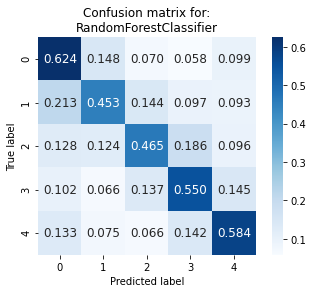

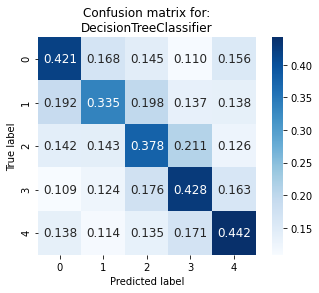

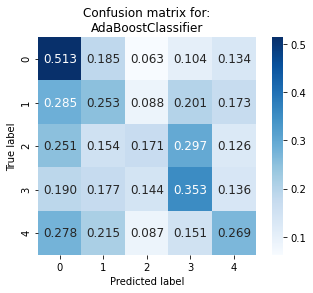

In [42]:
#Visualizing the confusion matrix for each classifier with 5 buckt approach
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

for i,model in enumerate([clf_A,clf_B, clf_C]):
    cm = confusion_matrix(y_test2, model.predict(X_test2))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":12}, 
            cmap='Blues', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));
    #plt.savefig(f'Confusion matrix for:{format(model.__class__.__name__)}.png', transparent=True)